# Estimating Indirect Nutrient Load from PT

# Imports

In [2]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

# Helper Function 

In [3]:
# Define the function to sort the files based on the time
def sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('_')[-1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Inputs

In [4]:
# Define paths for coastal wetland shapefiles
GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # Add leading slash to make it an absolute path
CW_path = os.path.join(GIS_LAYERS, 'Coastalwetland/hitshoreline')

#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'

# Paths to specific coastal wetland shapefiles with different inundation levels that have 50 meter buffer from the shoreline
CW_avg_path = os.path.join(CW_path, 'Wetland_connected_avg_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_low_path = os.path.join(CW_path, 'wetlands_connected_low_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_high_path = os.path.join(CW_path, 'wetlands_connected_high_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_surge_path = os.path.join(CW_path, 'wetlands_connected_surge_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')

# Load coastal wetland shapefiles as GeoDataFrames
CW_avg = gpd.read_file(CW_avg_path)
CW_low = gpd.read_file(CW_low_path)
CW_high = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)

# Define the path to FVCOM model output files
data_dir = '/home/abolmaal/modelling/FVCOM/Huron/output'
files = glob.glob(os.path.join(data_dir, "updated_FVCOM_Huron_*.nc"))
files.sort(key=sort_key)
# Define the path to the FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'


# Path to nutrient load data CSV and load the CSV
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/StreamWatresheds_total_N_P.csv'
Direct_Nutrient = pd.read_csv(Direct_Nutrient_load)

# Check and rename columns in the CSV file to match NetCDF data requirements
required_columns = {'Group_id': 'group_id', 'WetLoad_TN_kgcellday': 'WetLoad_TN_kgcellday', 'WetLoad_TP_kgcellday': 'WetLoad_TP_kgcellday'}

# Outputs

In [ ]:
output_path = '/home/abolmaal/modelling/FVCOM/Huron/results'
output_figures = '/home/abolmaal/modelling/FVCOM/Huron/figures'

# Define the file names to the FVCOM model output
originalFVCOM = 'LakeHuronparticletracking_2023_original.shp'


# file name for Intersected FVCOM model output with coastal wetlands

Intersection_PTCW_Avg = 'Intersections_Avg_PTCW.csv'
Intersection_PTCW_high = 'Intersections_high_PTCW.csv'
Intersection_PTCW_low = 'Intersections_low_PTCW.csv'
Intersection_PTCW_surge = 'Intersections_surge_PTCW.csv'

# monthly average of the Intersected FVCOM model output with coastal wetlands
Intersection_PTCW_Avg_monthly = 'Intersections_Avg_PTCW_monthly.csv'
Intersection_PTCW_high_monthly = 'Intersections_high_PTCW_monthly.csv'
Intersection_PTCW_low_monthly = 'Intersections_low_PTCW_monthly.csv'
Intersection_PTCW_surge_monthly = 'Intersections_surge_PTCW_monthly.csv'
###################################################################
GroupIdcount = 'group_id_counts.csv'
Non_Intersection_avg = 'Non_Intersection_avg.csv'
Non_Intersection_high = 'Non_Intersection_high.csv'
Non_Intersection_low = 'Non_Intersection_low.csv'
Non_Intersection_surge = 'Non_Intersection_surge.csv'

# Parameters

In [6]:
# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface

# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcellday'
fieldDirectTP = 'WetLoad_TP_kgcellday'

# Main Functions


## Create a geodatafram from the particle tracking outputs

In [30]:
import geopandas as gpd
import numpy as np
import pandas as pd
from dask.delayed import delayed
import xarray as xr
from shapely.geometry import Point
import dask  # Import Dask to access dask.compute
from dask import compute  # Import the specific compute function
import gc  # To manually collect garbage and free up memory
from dask.distributed import Client


# Limit the number of workers and threads
client = Client(n_workers=2, threads_per_worker=2)  # Adjust as needed

print(client)
# Function to remove overlap in time
def remove_overlap(datasets):
    # Remove the first time step of each dataset except for the first one
    datasets[1:] = [ds.sel(time=slice(ds['time'][1], None)) for ds in datasets[1:]]
    return datasets

# Function to process a single file and convert to GeoDataFrame
@delayed
def process_file(file):
    # Open the dataset lazily with xarray (no data loaded yet)
    with xr.open_dataset(file) as ds:
        selected_vars = ds[['time', 'group_id', 'group_number', 'longitude', 'latitude']]

        # Perform operations like longitude correction
        selected_vars['longitude'].values = np.where(selected_vars['longitude'].values > 180, 
                                                     selected_vars['longitude'].values - 360, 
                                                     selected_vars['longitude'].values)

        # Convert xarray to pandas dataframe
        PT_df = selected_vars.to_dataframe().reset_index()

        # Create GeoDataFrame from the DataFrame
        PT_gdf = gpd.GeoDataFrame(PT_df, geometry=gpd.GeoSeries.from_xy(PT_df['longitude'], PT_df['latitude']))

        # Set the CRS and reproject if necessary
        PT_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
        PT_gdf = PT_gdf.to_crs('EPSG:3174')

        # Release memory after processing the dataset
        del ds, selected_vars, PT_df  # Delete variables no longer needed
        gc.collect()  # Force garbage collection to release memory

        return PT_gdf

# Use dask.delayed to process each file (process files in smaller batches to avoid memory overload)
batch_size = 2  # Process in smaller batches of 2 files at a time
batches = [files[i:i + batch_size] for i in range(0, len(files), batch_size)]

all_gdfs = []

# Process each batch separately
for batch in batches:
    all_delayed = [process_file(file) for file in batch]
    batch_gdfs = compute(*all_delayed)  # Use dask.compute here
    all_gdfs.extend(batch_gdfs)  # Append the GeoDataFrames from this batch

    # Manually trigger garbage collection after each batch to release memory
    gc.collect()

# Now combine the GeoDataFrames from all batches into one
final_gdf = pd.concat(all_gdfs, ignore_index=True)

# Set final CRS if necessary
#final_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
#final_gdf = final_gdf.to_crs('EPSG:3174')

# Final GeoDataFrame with all datasets
print(final_gdf)

/root/miniforge3/envs/pylag/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37383 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:35485' processes=2 threads=4, memory=15.62 GiB>


: 

In [8]:
PT_gdf = final_gdf

In [ ]:
CW_avg

# Calculated monthly Intersection Seperately for each month 

In [28]:
import os
import pandas as pd
import geopandas as gpd
import gc

def calculate_monthly_first_intersections(gdf, CW_avg, output_path, output_csv="Intersection_PTCW_Avg.csv", summary_csv="Intersection_PTCW_Avg_monthly.csv"):
    """
    Loop through each month in the dataset, find only the first intersection per particle, 
    and save the results to a single CSV file. Also calculates the percentage of 
    intersecting particles per month.

    Parameters:
    - gdf: GeoDataFrame with 'time', 'group_id', 'group_number', 'geometry'
    - CW_avg: GeoDataFrame representing the wetland shapefile
    - output_path: Directory where the CSV files should be saved
    - output_csv: Optional output CSV filename (default is "Intersection_PTCW_Avg.csv")
    - summary_csv: Optional summary CSV filename (default is "Intersection_PTCW_Avg_monthly.csv")

    Returns:
    - monthly_first_intersections_df: DataFrame of first-time intersections
    - summary_stats_df: DataFrame of intersection percentages per month
    """
    # Reset index if needed
    if 'time' in gdf.index.names:
        print("🔄 Resetting 'time' from index to column...")
        gdf = gdf.reset_index()

    if 'time' not in gdf.columns:
        print("❌ ERROR: 'time' column is missing!")
        return None, None

    gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')

    # Ensure CRS matches
    if gdf.crs != CW_avg.crs:
        print("🔄 Reprojecting gdf to match CW_avg CRS...")
        gdf = gdf.to_crs(CW_avg.crs)

    # Extract month
    gdf['month'] = gdf['time'].dt.to_period("M")

    # Precompute wetland union geometry using union_all() (no deprecation warning)
    wetland_union = CW_avg.geometry.union_all()

    # Initialize storage for results
    monthly_results = []
    summary_stats = []

    # Loop over each unique month
    unique_months = sorted(gdf['month'].unique())
    for month in unique_months:
        print(f"📅 Processing {month}...")

        monthly_gdf = gdf[gdf['month'] == month]
        total_particles = monthly_gdf[['group_id', 'group_number']].drop_duplicates().shape[0]

        # Find intersecting particles
        intersecting_particles = monthly_gdf[monthly_gdf['geometry'].intersects(wetland_union)]

        if not intersecting_particles.empty:
            # Find the first intersection per particle (by time)
            first_intersections = (
                intersecting_particles
                .sort_values(by=['group_id', 'group_number', 'time'])
                .groupby(['group_id', 'group_number'])
                .first()
                .reset_index()
            )

            total_first = first_intersections.shape[0]
            percentage = (total_first / total_particles) * 100 if total_particles > 0 else 0

            print(f"✅ {month}: {total_first} particles first-time intersected ({percentage:.2f}%)")

            first_intersections['month'] = str(month)

            # Perform spatial join to include relevant columns from CW_avg
            joined_gdf = gpd.sjoin(first_intersections, CW_avg, how='left', op='intersects')

            monthly_results.append(joined_gdf)
            summary_stats.append({'month': str(month), 'percentage': percentage})
        else:
            print(f"⚠️ {month}: No intersections found.")

        # Free memory after each month's processing
        del monthly_gdf, intersecting_particles, first_intersections, joined_gdf
        gc.collect()

    # Combine all results
    if monthly_results:
        monthly_first_intersections_df = pd.concat(monthly_results, ignore_index=True)
    else:
        monthly_first_intersections_df = pd.DataFrame()

    # Convert summary list to DataFrame
    summary_stats_df = pd.DataFrame(summary_stats)

    # Save both DataFrames to CSV in the provided output path
    # Save the first intersections data
    output_file = os.path.join(output_path, output_csv)
    monthly_first_intersections_df.to_csv(output_file, index=False)
    print(f"✅ Monthly first-time intersections saved to {output_file}")

    # Save the summary stats data
    summary_output_file = os.path.join(output_path, summary_csv)
    summary_stats_df.to_csv(summary_output_file, index=False)
    print(f"✅ Summary statistics saved to {summary_output_file}")

    # Return the results
    return monthly_first_intersections_df, summary_stats_df


In [10]:
#set the crs of cw_avg to 3174
CW_avg.to_crs('EPSG:3174', inplace=True)
CW_low.to_crs('EPSG:3174', inplace=True)
CW_high.to_crs('EPSG:3174', inplace=True)
CW_surge.to_crs('EPSG:3174', inplace=True)

## Intersectio with Avg Inun

In [29]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_avg,output_path, Intersection_PTCW_Avg, Intersection_PTCW_Avg_monthly)


NameError: name 'PT_gdf' is not defined

## High Inundation 

In [17]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_high,output_path, Intersection_PTCW_high)


📅 Processing 2023-01...
✅ 2023-01: 1553 particles first-time intersected (18.16%)
📅 Processing 2023-02...
✅ 2023-02: 1035 particles first-time intersected (12.11%)
📅 Processing 2023-03...
✅ 2023-03: 4319 particles first-time intersected (50.51%)
📅 Processing 2023-04...
✅ 2023-04: 3710 particles first-time intersected (43.39%)
📅 Processing 2023-05...
✅ 2023-05: 3920 particles first-time intersected (45.85%)
📅 Processing 2023-06...
✅ 2023-06: 4943 particles first-time intersected (57.81%)
📅 Processing 2023-07...
✅ 2023-07: 5500 particles first-time intersected (64.33%)
📅 Processing 2023-08...
✅ 2023-08: 6264 particles first-time intersected (73.26%)
📅 Processing 2023-09...
✅ 2023-09: 5500 particles first-time intersected (64.33%)
📅 Processing 2023-10...
✅ 2023-10: 4083 particles first-time intersected (47.75%)
📅 Processing 2023-11...
✅ 2023-11: 2724 particles first-time intersected (31.86%)
📅 Processing 2023-12...
✅ 2023-12: 2065 particles first-time intersected (24.15%)
📅 Processing 202

## Low Inundation

In [18]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_low,output_path, Intersection_PTCW_low)


📅 Processing 2023-01...
✅ 2023-01: 1434 particles first-time intersected (16.77%)
📅 Processing 2023-02...
✅ 2023-02: 888 particles first-time intersected (10.39%)
📅 Processing 2023-03...
✅ 2023-03: 3645 particles first-time intersected (42.63%)
📅 Processing 2023-04...
✅ 2023-04: 2925 particles first-time intersected (34.21%)
📅 Processing 2023-05...
✅ 2023-05: 3132 particles first-time intersected (36.63%)
📅 Processing 2023-06...
✅ 2023-06: 4176 particles first-time intersected (48.84%)
📅 Processing 2023-07...
✅ 2023-07: 4891 particles first-time intersected (57.20%)
📅 Processing 2023-08...
✅ 2023-08: 5426 particles first-time intersected (63.46%)
📅 Processing 2023-09...
✅ 2023-09: 4615 particles first-time intersected (53.98%)
📅 Processing 2023-10...
✅ 2023-10: 3395 particles first-time intersected (39.71%)
📅 Processing 2023-11...
✅ 2023-11: 2464 particles first-time intersected (28.82%)
📅 Processing 2023-12...
✅ 2023-12: 2031 particles first-time intersected (23.75%)
📅 Processing 2024

## Surge Inundation 

In [19]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_surge,output_path, Intersection_PTCW_surge)

📅 Processing 2023-01...
✅ 2023-01: 1576 particles first-time intersected (18.43%)
📅 Processing 2023-02...
✅ 2023-02: 1053 particles first-time intersected (12.32%)
📅 Processing 2023-03...
✅ 2023-03: 4586 particles first-time intersected (53.64%)
📅 Processing 2023-04...
✅ 2023-04: 3983 particles first-time intersected (46.58%)
📅 Processing 2023-05...
✅ 2023-05: 4228 particles first-time intersected (49.45%)
📅 Processing 2023-06...
✅ 2023-06: 5139 particles first-time intersected (60.11%)
📅 Processing 2023-07...
✅ 2023-07: 5678 particles first-time intersected (66.41%)
📅 Processing 2023-08...
✅ 2023-08: 6498 particles first-time intersected (76.00%)
📅 Processing 2023-09...
✅ 2023-09: 5754 particles first-time intersected (67.30%)
📅 Processing 2023-10...
✅ 2023-10: 4311 particles first-time intersected (50.42%)
📅 Processing 2023-11...
✅ 2023-11: 2830 particles first-time intersected (33.10%)
📅 Processing 2023-12...
✅ 2023-12: 2123 particles first-time intersected (24.83%)
📅 Processing 202

In [20]:
from memory_profiler import profile

@profile
def my_function():
    # Your function here
    pass

## Important Note

The following cells need to be run only **once**. After running them, **reset the kernel** and continue with the following part of the notebook. 

### Steps:
1. Run the cells below.
2. Once completed, reset the kernel:
   - Go to the **Kernel** menu → **Restart Kernel**.
3. After resetting the kernel, continue with the rest of the notebook as usual.

---

This step is necessary to free up memory and ensure that all variables are cleared before proceeding with the next steps.


## empty the memory

In [22]:
# Example: After processing each batch or month
del intersections_df, monthly_percentages_df, PT_gdf  # Delete intermediate variables
gc.collect()  # Manually run garbage collection to free memory

214

# Add NP load to the particles

## Reading the Intersection files

In [23]:
# read the csv files from output path
first_intersections_avgInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg))
first_intersections_highInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_high))
first_intersections_lowInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_low))
first_intersections_surgeInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_surge))

## Function to merge Intersection with NP Load

In [24]:
def merged_ZonalStats(first_intersections_avgInun, Direct_Nutrient):
    """
    Merges particle tracking data with nutrient load data and adjusts nutrient loads
    based on occurrences of each group_id.

    Parameters:
    - first_intersections_avgInun: DataFrame containing particle tracking data with a 'group_id' column.
    - Direct_Nutrient: DataFrame containing nutrient load data with 'group_id', 'WetLoad_TN_kg2', and 'WetLoad_TP_kg2' columns.

    Returns:
    - merged_data: DataFrame with merged data and adjusted 'WetLoad_TN_kg2' and 'WetLoad_TP_kg2' values.
    - returns the wetload values divided by the group_id counts the get the values for each group_id count
    """
    
    # Step 1: Count occurrences of each group_id in the NetCDF file and store as a dictionary
    group_id_counts = first_intersections_avgInun['group_id'].value_counts().to_dict()
    
    # Step 2: Merge particle data with nutrient load data
    merged_data = pd.merge(first_intersections_avgInun, Direct_Nutrient, on='group_id', how='left')
    
    # Step 3: Adjust WetLoad_TN_kg2 and WetLoad_TP_kg2 values by dividing by group_id count
    merged_data[fieldDirectTN] = merged_data.apply(
        lambda row: row[fieldDirectTN] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTN]) else None,
        axis=1
    )

    merged_data[fieldDirectTN] = merged_data.apply(
        lambda row: row[fieldDirectTN] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTN]) else None,
        axis=1
    )
    merged_data[fieldDirectTP] = merged_data.apply(
        lambda row: row[fieldDirectTP] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTP]) else None,
        axis=1
    )
    # drop unnecessary columns
    #merged_data.drop(columns=['index_right','ID','GRIDCODE','start_lat','start_lon'], inplace=True)
    return merged_data

## merging the Intersections for different lake levels

In [25]:
# Merge particle tracking data_average inundation with nutrient load data and adjust nutrient loads
merged_data_avg = merged_ZonalStats(first_intersections_avgInun, Direct_Nutrient)
# Merge particle tracking data_high inundation with nutrient load data and adjust nutrient loads
merged_data_high = merged_ZonalStats(first_intersections_highInun, Direct_Nutrient)

# Merge particle tracking data_low inundation with nutrient load data and adjust nutrient loads
merged_data_low = merged_ZonalStats(first_intersections_lowInun, Direct_Nutrient)

# Merge particle tracking data_surge inundation with nutrient load data and adjust nutrient loads
merged_data_surge = merged_ZonalStats(first_intersections_surgeInun, Direct_Nutrient)

## Plot Function 

In [26]:
def plot_wetload_distribution_TN_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    color_map, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height] 
    colorbar_outside=True  
    #save_fig=True
    
):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background,
    with three zoomed-in maps inside or near the main map. 
    Each zoom-in region is enclosed with a colored box that matches the zoomed-in map's title color.
    """

    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data['WetLoad_TN_kgcellday'].values

    # Create the figure and main axis
    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Nitrogen Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter for bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot the main extent
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tn, 
        gridsize=50, 
        cmap=color_map, 
        norm=LogNorm(), 
        reduce_C_function=np.sum, 
        zorder=40
    )

    # Add color bar for main extent with increased font size
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Nitrogen Load (kg/cell/day)', fontsize=font_size + 5)  # Increased font size for label
    cbar_main.ax.tick_params(labelsize=font_size + 2)  # Increase font size for tick labels

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    # Define inset positions, extents, and titles
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    # Iterate over three insets
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        # Create inset axis
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        
        # Plot inset bathymetry
        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        # Add hexbin plot for the inset zoom area
        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tn, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(), 
            reduce_C_function=np.sum, 
            zorder=40
        )

        # Set inset title with matching color
        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Add rectangle to highlight the zoomed-in region with matching color
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        # **NEW CODE**: Draw a colored border around each zoom-in box
        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]),  # Position of the inset box on the figure
            inset_pos[2],                  # Width of the inset box
            inset_pos[3],                  # Height of the inset box
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)
        
    # Save the plot
    plt.savefig (output_figures + '/WetLoadDistribution_AvgInun_Nitrogen_Zoombox_newrun.png',dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_13565/3017916665.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


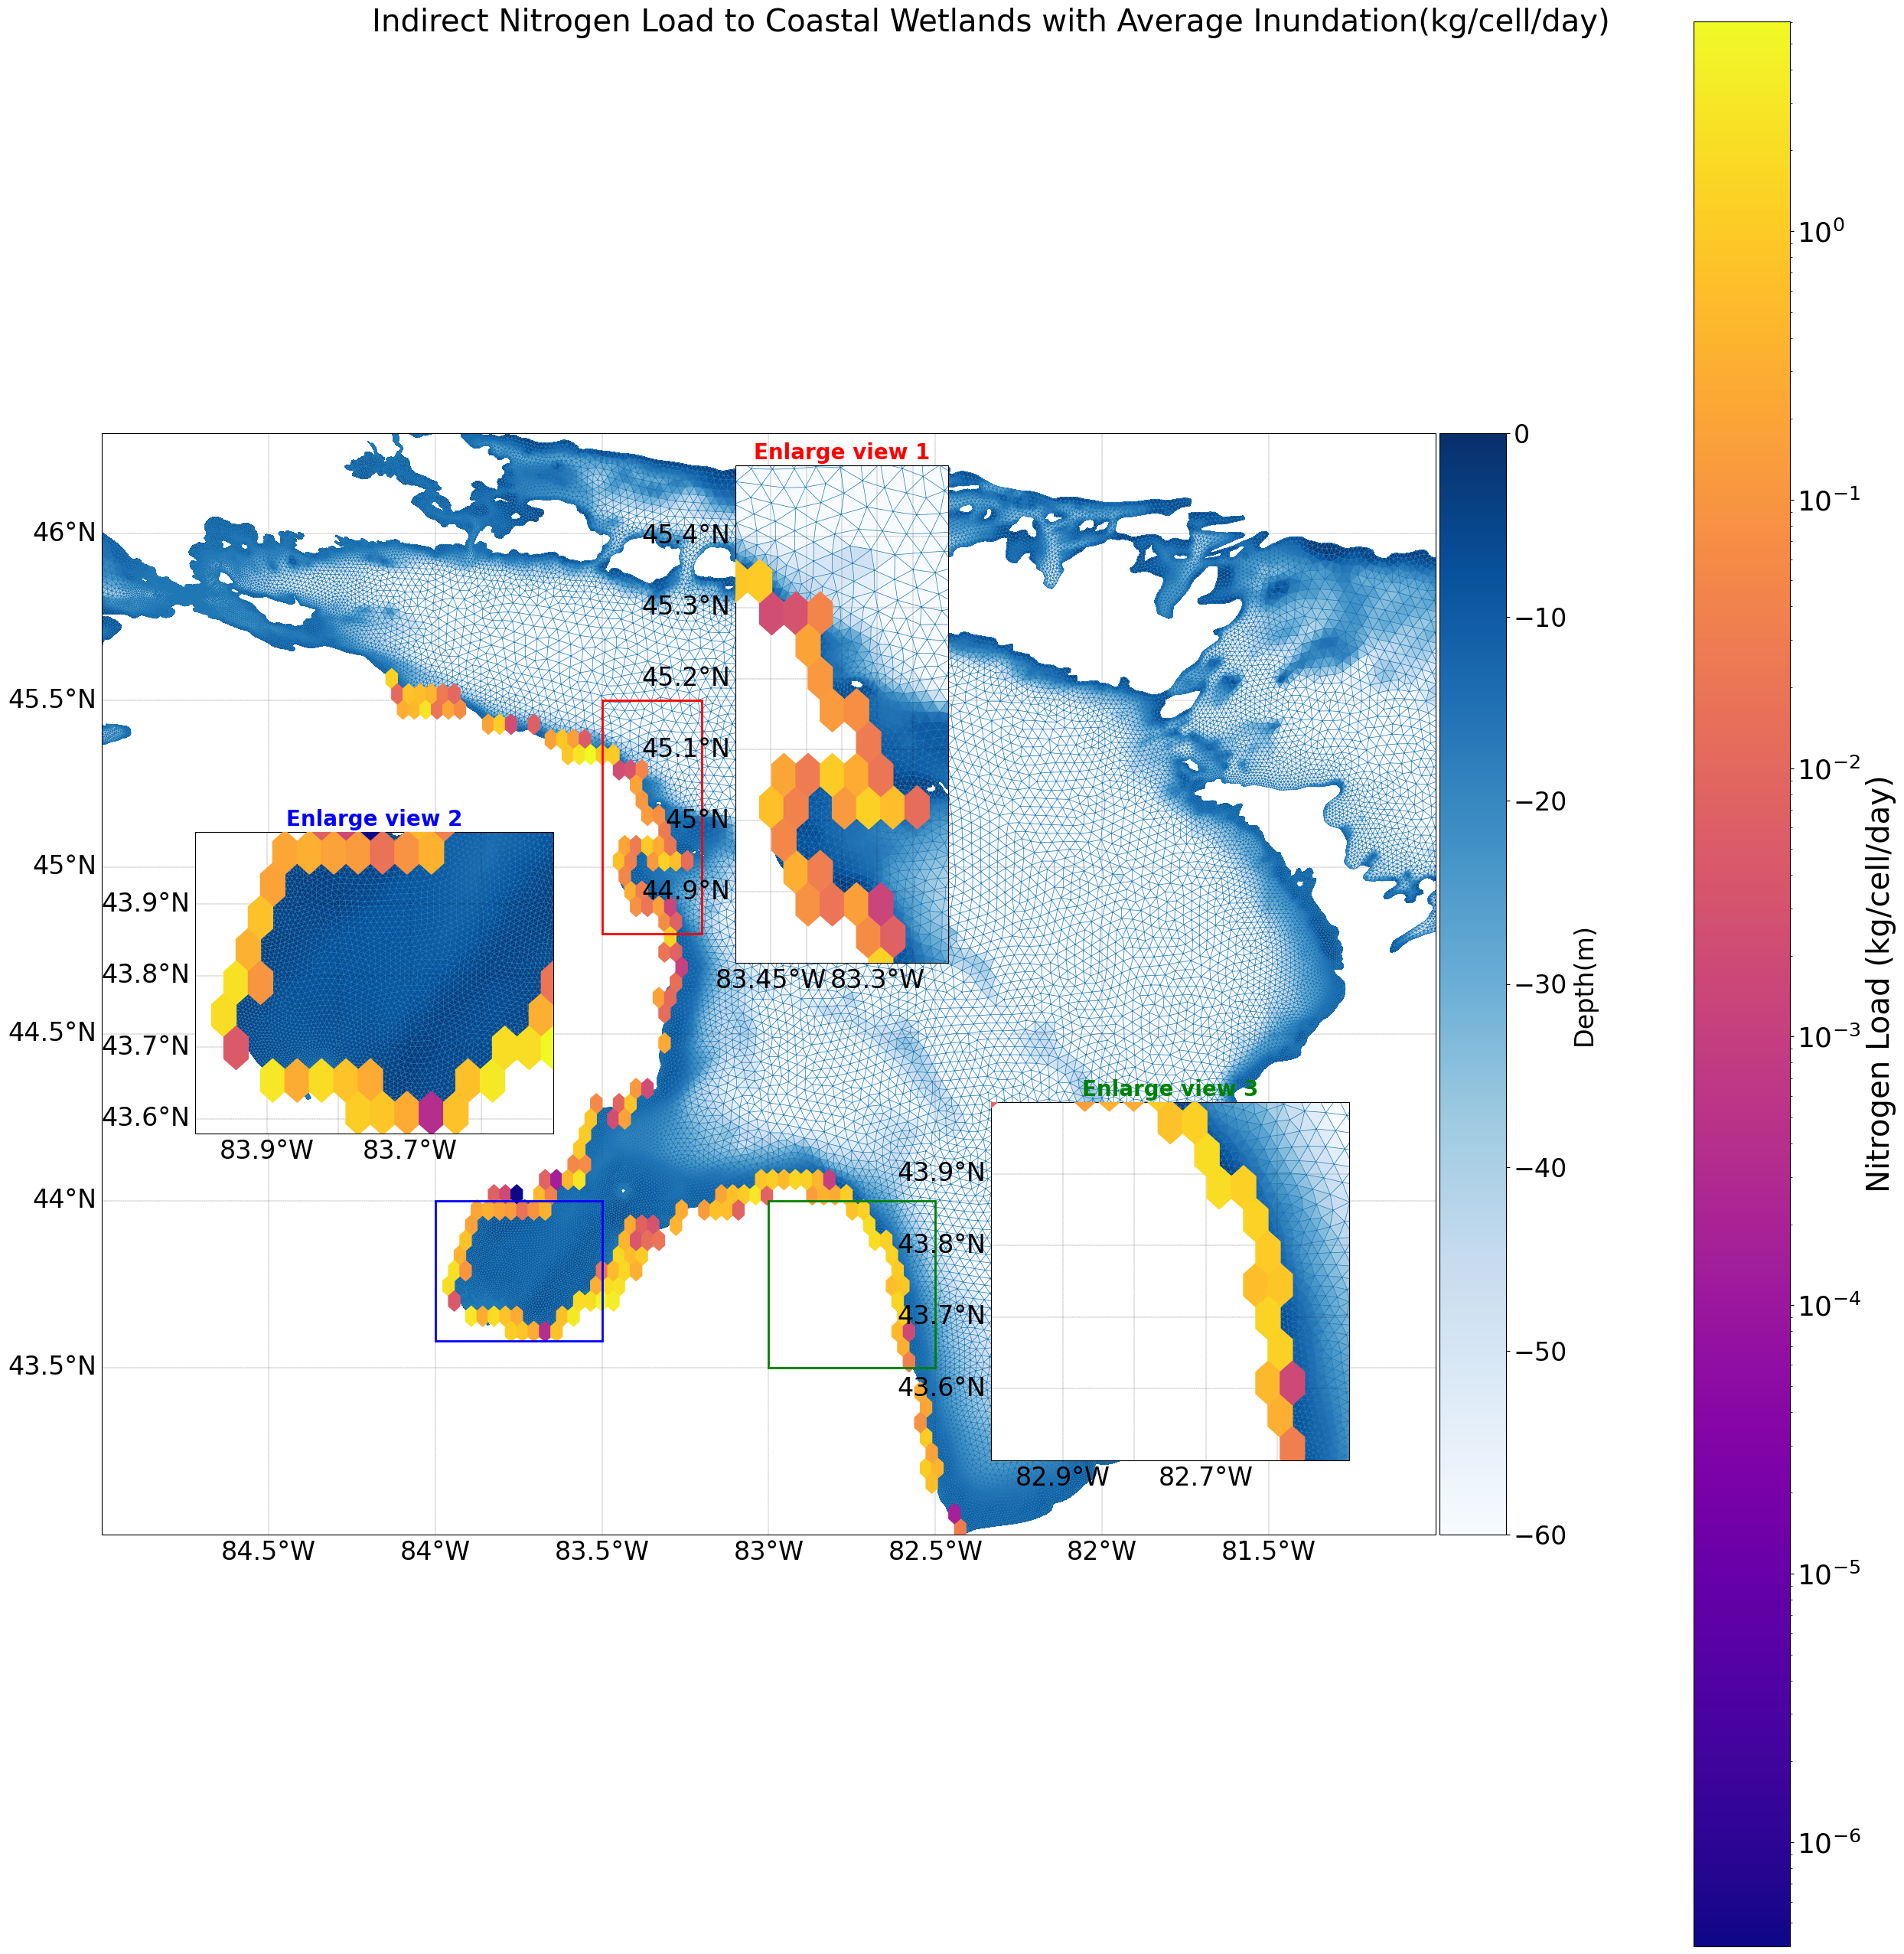

In [27]:
plot_wetload_distribution_TN_with_three_insets(
    merged_data=merged_data_avg,
    grid_metrics_file_name=grid_metrics_file_name,
    main_extents=[275,279,43,46.3],  # Main extent
    zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
    zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
    zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in extent
    color_map=plasma_cmap,  # Colormap for nitrogen
    font_size=24,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height]
    colorbar_outside=True,
    title="Indirect Nitrogen Load to Coastal Wetlands with Average Inundation(kg/cell/day)"

)

## PLot monthly Intersections 

In [ ]:

def plot_monthly_intersection_barchart(summary_df, title="Monthly % of First-Time Intersections"):
    """
    Creates a bar chart showing the percentage of particles that intersected 
    the coastal wetland for the first time each month.

    Parameters:
    - summary_df: DataFrame with 'month' and 'percentage' columns
    - title: Title for the plot

    Returns:
    - None (displays the plot)
    """
    # Ensure the data is sorted by month
    summary_df = summary_df.sort_values(by="month")

    # Plot setup
    plt.figure(figsize=(12, 6))
    bars = plt.bar(summary_df["month"], summary_df["percentage"], color='skyblue', edgecolor='black')

    # Annotate each bar with the percentage
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%", 
                 ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)
    plt.ylabel("Intersection Percentage (%) ", fontsize=12)
    plt.xlabel("Month", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_figures + '/Monthly_First_Time_Intersections_low_particlemiddleplume.png')
    plt.show()



In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)
